# HW 8: Anomaly Detection and Recommender Systems

In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex
 
# set path
import os
os.chdir('%s/courses/coursera_ml008/hw8' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

# plotting options
%matplotlib inline
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

/Users/rwk7t/Development/dst/courses/coursera_ml008/hw8


## 1 Anomaly Detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the through-put (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)},\dots,x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. You will be using `ex8.m` for this part of the exercise.

The first part of `ex8.m` will visualize the dataset as shown in Figure 1.

<img src="fig1.png" width=500/>

In [2]:
ex8data1 = scipy.io.loadmat('ex8data1.mat')
ex8data1.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [3]:
X     = ex8data1['X'   ]
X_val = ex8data1['Xval']
y_val = ex8data1['yval']
X.shape, X_val.shape, y_val.shape

((307, 2), (307, 2), (307, 1))

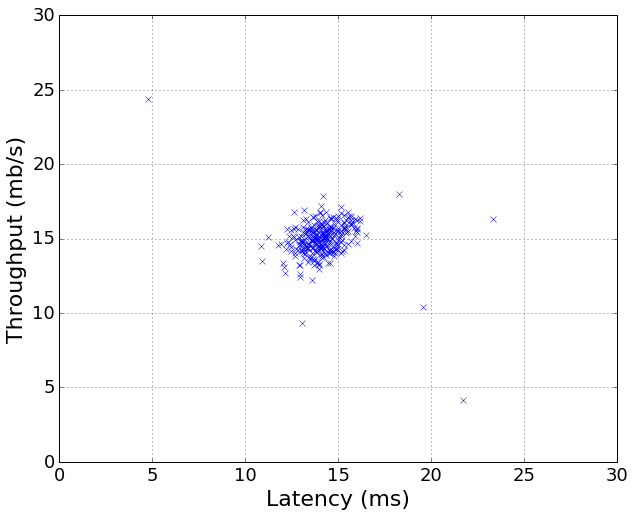

In [4]:
plt.plot(X[:,0], X[:,1], 'bx')
plt.grid()
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.axis([0, 30, 0, 30])
plt.show()

### 1.1 Gaussian Distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

Given a training set $\{x^{(1)},\dots,x^{(m)}\}$ (where $x^{(i)} \in \Bbb{R}^n$), you want to estimate the Gaussian distribution for each of the features $x_i$. For each feature $i = 1 \dots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)},\dots,x_i^{(m)}\}$ (the $i$-th dimension of each example).

The Gaussian distribution is given by

\begin{align}
P\left(x; \mu, \sigma^2\right) = \frac{1}{\sqrt{2 \pi \sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}},
\end{align}

where $\mu$ is the mean and $\sigma^2$ controls the variance.

For the multivariant Gaussian distribution:

\begin{align}
P\left(x; \mu, \Sigma\right) = \frac{1}{(2 \pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp\left\{(x-\mu)^T\Sigma^{-1}(x-\mu)\right\},
\end{align}

### 1.2 Estimating parameters for a Gaussian

You can estimate the parameters, $(\mu_i, \sigma_i^2)$, of the $i$-th feature by using the following equations. To estimate the mean, you will use:

\begin{align}
\mu_i = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}
\end{align}

and for the variance you will use:

\begin{align}
\sigma_i^2 = \frac{1}{m}\sum_{j=1}^m \left(x_i^{(j)} - \mu_i \right)^2
\end{align}

Your task is to complete the code in `estimateGaussian.m`. This function takes as input the data matrix $X$ and should output an $n$-dimension vector `mu` that holds the mean of all the $n$ features and another $n$-dimension vector `sigma2` that holds the variances of all the features. You can implement this using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer). Note that in Octave/MATLAB, the var function will (by default) use $\frac{1}{m-1}$ instead of $\frac{1}{m}$, when computing $\sigma^2$.

Once you have completed the code in `estimateGaussian.m`, the next part of `ex8.m` will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to Figure 2. From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

<img src="fig2.png" width=700/>

In [5]:
def estimate_gaussian(X):
    mu     = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

In [6]:
mu, sigma2 = estimate_gaussian(X)
mu.shape, sigma2.shape

((2,), (2,))

In [7]:
def multivariate_gaussian(X, mu, sigma2):
    
    from numpy.linalg import matrix_rank as rank
    from numpy.linalg import det as det
    from numpy.linalg import pinv as pinv
    from numpy import pi, diagonal
    
    m, n   = X.shape
    Z      = (np.asmatrix(X)-np.asmatrix(mu)).T
    S      = np.asmatrix(np.diag(np.asarray(sigma2).reshape(n,)) if rank(sigma2)==1 else sigma2)
    assert(Z.T.shape==X.shape)
    assert(S.shape==(n,n))
    
    p = (1.0/((2*pi)**(0.5*n)*det(S)**(0.5)))*np.exp(-0.5*diagonal(Z.T*pinv(S)*Z))
    return p

In [8]:
p = multivariate_gaussian(X, mu, sigma2)
p.shape

(307,)

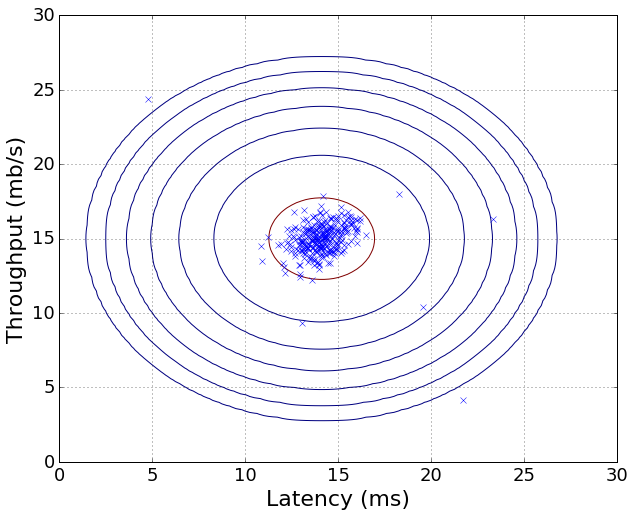

In [9]:
plt.plot(X[:,0], X[:,1], 'bx')
X1 = np.mgrid[0:35.5:0.25]
X2 = X1.copy()
X1, X2 = np.meshgrid( X1, X2 )

Z = multivariate_gaussian(np.c_[X1.T.ravel().T, X2.T.ravel().T], mu, sigma2)
Z = Z.reshape(np.shape(X1)[0], np.shape(X1)[1]).T
a = np.arange(-20, 0, 3)
b = np.ones_like(a, dtype=np.float)*10

plt.contour(X1, X2, Z, pow(b, a))
plt.axis([0, 30, 0, 30])
plt.grid()
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

### 1.3 Selecting the Threshold, $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the $F_1$ score on a cross validation set.

You should now complete the code in `selectThreshold.m`. For this, we will use a cross validation set $\{(x_{cv}^{(1)}, y_{cv}^{(1)}), \dots , (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p(x^{(i)}_{cv})$. The vector of all of these probabilities $p(x^{(1)}_{cv}), \dots , p(x^{(m_{cv})})$ is passed to `selectThreshold.m` in the vector `pval`. The corresponding labels $y^{(1)}_{cv}, \dots , y^{(m_{cv})}_{cv}$ is passed to the same function in the vector `yval`.

The function `selectThreshold.m` should return two values; the first is the selected threshold $\epsilon$. If an example $x$ has a low probability $p(x) \lt \epsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you’re doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision (*prec*) and recall (*rec*):

$$F_1 = \frac{2·prec·rec}{prec + rec},$$

You compute precision and recall by:
￼
$$prec = \frac{tp}{tp+fp}$$

$$rec = \frac{tp}{tp+fn}$$

￼￼where
  * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
  * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
  * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code `selectThreshold.m`, there is already a loop that will try many different values of $\epsilon$ and select the best $\epsilon$ based on the $F_1$ score. You should now complete the code in `selectThreshold.m`. You can implement the computation of the $F_1$ score using a for-loop over all the cross validation examples (to compute the values $tp$, $fp$, $fn$). You should see a value for epsilon of about `8.99e-05`.

**Implementation Note:** In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples. This can be implemented by `Octave/MATLAB’s` equality test between a vector and a single number. If you have several binary values in an $n$-dimensional binary vector $v \in {0,1}^n$, you can find out how many values in this vector are 0 by using: `sum(v == 0)`. You can also apply a logical and operator to such binary vectors. For instance, let `cvPredictions` be a binary vector of the size of your number of cross validation set, where the $i$-th element is 1 if your algorithm considers $x_{cv}^{(i)}$ an anomaly, and 0 otherwise. You can then, for example, compute the number of false positives using: `fp = sum((cvPredictions == 1) & (yval == 0))`.

Once you have completed the code in `selectThreshold.m`, the next step in ex8.m will run your anomaly detection code and circle the anomalies in the plot (Figure 3).

<img src="fig3.png" width=500/>

In [10]:
def select_threshold(y, p):

    epsilon   = 0.0
    F1        = 0.0
    step_size = (max(p)-min(p))/1000.0
    y         = y.ravel()
    
    for eps in np.arange(start=min(p), stop=max(p)+step_size, step=step_size):        
        pred = (p < eps)
        tp   = np.sum((pred==1)&(y==1), dtype=np.float)
        fp   = np.sum((pred==1)&(y==0), dtype=np.float)
        fn   = np.sum((pred==0)&(y==1), dtype=np.float)
        #tn   = np.sum((pred==0)&(y==0), dtype=np.float)
        
        prec = tp/(tp + fp)
        rec  = tp/(tp + fn)
        f1   = (2.0*prec*rec)/(prec + rec)
        
        if f1 > F1:
            F1      = f1
            epsilon = eps
            
    return epsilon, F1

In [11]:
p_val   = multivariate_gaussian(X_val, mu, sigma2)
eps, F1 = select_threshold(y_val, p_val)
eps, F1

(8.9908527792694959e-05, 0.87500000000000011)

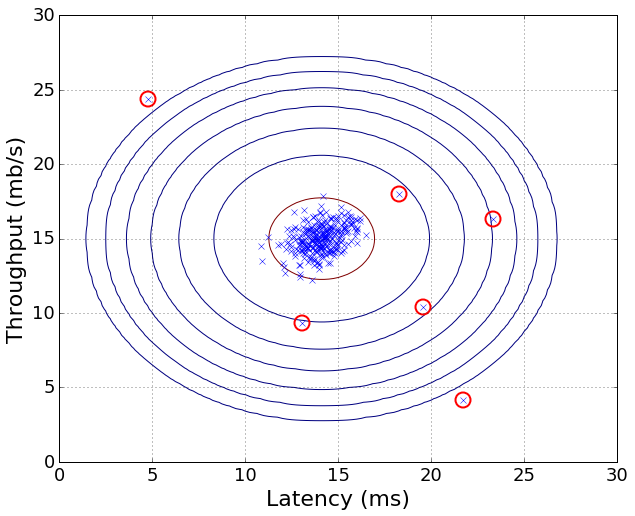

In [12]:
plt.plot(X[:,0], X[:,1], 'bx')
X1 = np.mgrid[0:35.5:0.25]
X2 = X1.copy()
X1, X2 = np.meshgrid(X1, X2)

Z = multivariate_gaussian(np.c_[X1.T.ravel().T, X2.T.ravel().T], mu, sigma2)
Z = Z.reshape(np.shape(X1)[0], np.shape(X1)[1]).T
a = np.arange(-20, 0, 3)
b = np.ones_like(a, dtype=np.float)*10
plt.contour(X1, X2, Z, pow(b, a))

X_out = X[p < eps]
plt.plot(
    X_out[:,0], 
    X_out[:,1], 'ro', lw=2, ms=15, mew=2, fillstyle='none'
)

plt.axis([0, 30, 0, 30])
plt.grid()
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

### 1.4 High dimensional dataset

The last part of the script `ex8.m` will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the training data $X$ from which you estimated the Gaussian parameters, and do so for the the cross-validation set `Xval`. Finally, it will use `selectThreshold` to find the best threshold $\epsilon$. You should see a value $\epsilon$ of about `1.38e-18`, and 117 anomalies found.

In [13]:
ex8data2 = scipy.io.loadmat('ex8data2.mat')
ex8data2.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [14]:
X     = ex8data2['X'   ]
X_val = ex8data2['Xval']
y_val = ex8data2['yval']
X.shape, X_val.shape, y_val.shape

((1000, 11), (100, 11), (100, 1))

In [15]:
# train
mu, sigma2 = estimate_gaussian(X)
mu.shape, sigma2.shape

((11,), (11,))

In [16]:
# probabilities
p = multivariate_gaussian(X, mu, sigma2)
p.shape

(1000,)

In [17]:
p_val   = multivariate_gaussian(X_val, mu, sigma2)
eps, F1 = select_threshold(y_val, p_val)
eps, F1

(1.3772288907613575e-18, 0.61538461538461542)

In [18]:
# anamolies found
np.sum(p < eps)

117